## Lennard-Jones Potential
<br>


$$V(r)=4\epsilon\big[\big(\frac{\delta}{r}\big)^{12}-\big(\frac{\delta}{r}\big)^6\big]$$
<br>
<br>
Suppose we have $m$ molecules whose positions are denoted by $\textbf{a}_m$ that exist in $\mathbb{R^n}$. Let $\textbf{A}$ be an $m\times{n}$ matrix that contains the molecules, and let $\textbf{r}$ be a $m\times{m}$ square symetric matrix where $r_{ij}=\|\textbf{A}_i-\textbf{A}_j\|$ 
<br>
<br>
$$
\begin{align*}
\textbf{A}&=\left[\begin{matrix} \textbf{a}_1\\\textbf{a}_2\\\vdots\\\textbf{a}_m\end{matrix}\right]=
\left[\begin{matrix} a_{1_1} & a_{1_2} & \dots & a_{1_n}\\ a_{2_1} & \ddots & & \\\vdots & & \ddots &\\a_{m_1} & & & a_{m_n}\end{matrix}\right]\\
\textbf{r}&=\left[\begin{matrix} \|\textbf{A}_1-\textbf{A}_1\| & \dots & \|\textbf{A}_1-\textbf{A}_j\| \\ \vdots &\ddots & \\ \|\textbf{A}_i-\textbf{A}_1\| & & \|\textbf{A}_m-\textbf{A}_m\| \end{matrix}\right]
\end{align*}
$$
<br>
<br>
The total energy $E$ of a system $\textbf{A}$ with a distance matrix $\textbf{r}$ is defined as the sum of the LJ energy between every molecule.
<br>
<br>
$$E(\textbf{A})=\sum_{i=0}^{m-1}\sum_{j=i+1}^{m}V(r_{ij})\quad {\scriptsize \textrm{in total, } {m\choose 2 } {\textrm{ terms. (upper triangle of }}\textbf{r})}
$$

For computational purposes, only the upper triangle of $\textbf{r}$ is calculated, and it is flattened to 1 dimension. The final energy calculation then only needs one iterator over the span of $\textbf{r}$

In [1]:
import numpy as np


def Energy(A,dim):
    def V(r,epsilon=1,delta=1):#Returns the potential between two molecules of distance r
        return 4*epsilon*((delta/r)**12 - (delta/r)**6)
    
    def r(A):#Returns a distance matrix. Only the upper triangle needs to be calculated; the rest can be 0
        r=[]
        for i in range(0,A.shape[0]-1):
            for j in range(i+1,A.shape[0]):
                r.append(np.sqrt(np.dot(A[i]-A[j],A[i]-A[j])))
        return np.asarray(r)
    A=np.reshape(A,(int(len(A)/dim),dim))
    r1=r(A)
    total=0.
    for i in range(len(r1)):
            total+=V(r1[i])
    return total.flatten()

## Lennard Jones Force Function

<br>

Lets examine the force vector $\textbf{F}$ on a location $\textbf{x}$ generated from a particle $\textbf{a}$ in $\mathbb{R^n}$ space. Let $(x_1,x_2,\dots,x_n)$ denote the basis vectors. <br>
For simplicity,  $\epsilon,\delta$ =1.
<br>
<br>
$$
\begin{align*}
\textbf{F}(\textbf{x})&=\nabla V\\
&=4\nabla\big[\big(\frac{1}{r}\big)^{12}-\big(\frac{1}{r}\big)^6\big]\\
&= \big[-\frac{48}{r^{13}}+\frac{24}{r^7}\big]\nabla r\\
&= \big[-\frac{48}{r^{13}}+\frac{24}{r^7}\big]\big(\frac{\partial}{\partial x_1}\hat x_1+\frac{\partial}{\partial x_2}\hat x_2+\dots+\frac{\partial}{\partial x_n}\hat x_n\big)\big((a_1-x_1)^2+(a_2-x_2)^2+\dots+(a_n-x_n)^2\big)^{\frac{1}{2}}\\
&= \big[\frac{48}{r^{14}}-\frac{24}{r^8}\big]\big((a_1-x_1)\hat x_1+(a_2-x_2)\hat x_2 + \dots + (a_n-x_n)\hat x_n\big)\\
&= \big[\frac{48}{r^{14}}-\frac{24}{r^8}\big](\textbf{a}-\textbf{x})
\end{align*}
$$
<br>
<br>
Due to the principle of superposition, we can easily extrapolate to include $m$ molecules
<br>
<br>
$$\textbf{F}(\textbf{x})=\sum_{i=1}^{m}\big[\frac{48}{r_i^{14}}-\frac{24}{r_i^8}\big](\textbf{a}_i-\textbf{x})
$$
<br>
<br>
If this force function was evaluated at every particle location $\textbf{a}_m$, you would have a complete force matrix. The direction of greatest increase for each particle would be specifically calculated based on the energy of the system $\textbf{A}$, and each location parameter $a_{mn}$ would be automatically filled in by the gradient. Thus,

$$\nabla E=\left[\begin{matrix}\textbf{F}(\textbf{a}_1) \\ \textbf{F}(\textbf{a}_2) \\ \vdots \\ \textbf{F}(\textbf{a}_m)\end{matrix}\right]
$$
<br>
<br>
Within the evaluation of $\textbf{F}$, the contribution of a particle onto itself must manually removed, or else $r$ calculation will yield a divide by 0.

In [2]:
def gradientE(A,dim):
    def F(A,x):
        total=np.zeros([len(x)])
        for i in range(A.shape[0]):
            r=np.sqrt(np.dot(A[i]-x,A[i]-x))
            k=(48/r**14)-(24/r**8)
            total+=k*(A[i]-x)
        return total

    A=np.reshape(A,(int(len(A)/dim),dim))
    force=np.zeros(A.shape)
    for i in range(A.shape[0]):
        A1=A.copy()
        A1=np.delete(A1,i,0)
        force[i]=F(A1,A[i])

    return force.flatten()

In [3]:
#Accuracy Check
from LJ import LJ,LJ_force

def init(m,n):#Returns a random, normalized array of size mxn
    A=np.random.uniform(low=-1.,high=1.,size=(m,n))
    return A
def error(x,y): #I'm using the LJ from your optimization repository as the theoretical
    return (100*(x-y)/x)
energy=0.
gradient=0.
for i in range(100):#Average the error over 100 random systems of A
    A=init(3,3)
    energy+=np.abs(error(Energy(A.flatten(),3),LJ(A.flatten(),3)))
    gradient+=np.abs(error(np.linalg.norm(gradientE(A.flatten(),3)),np.linalg.norm(LJ_force(A.flatten(),3))))
energy=float(energy/100.)
graident=gradient/100
print('Percentage Error of LJ-Potential: ',energy)
print('Percentage Error of LJ-Force: ', gradient)   

Percentage Error of LJ-Potential:  7.943700230893098e-14
Percentage Error of LJ-Force:  3.0213588337730833e-12


## Conjugate Gradient for Non-Linear Systems
<br>

$\text{Algorithm detailed in }\small\textit{Numerical Optimization} \text{ by Nocedal & Wright.}$
### Conjugate Gradient
$\text{Given } x_0;$<br>
$\text{Evalute } f_0=f(x_0), \nabla f_0= \nabla f(x_0);$<br>
$\text{Set }p_0=- \nabla f_0, k\leftarrow0$<br>
$\begin{align*} \textbf{while } \nabla &f_k \neq 0 \\
&\text{Compute } \textbf{LineSearch}(\alpha_k) \text{ and set }x_{k+1} = x_k + \alpha_kp_k;\\
&\text{Evalute } \nabla f_{k+1}; \\
\beta_{k+1}^{\text{PR}} &\leftarrow \text{max}\left(\frac{(\nabla f_{k+1}-\nabla f_{k})^T \nabla f_{k+1}}{\nabla f_k^T \nabla f_k},0\right);\\
p_{k+1} &\leftarrow -\nabla f_{k+1} + \beta_{k+1}^\text{PR}p_k;\\
k &\leftarrow k + 1
\end{align*}$
<br>
<br>

In [151]:
import myscipy_optimize

def CG(f,x0,fprime=None,args=(),amin=1e-100,amax=1e100,gtol=1e-4,maxiter=100,eps = np.sqrt(np.finfo(float).eps)):#Returns [f(x),x]
    
   

    def approx_jac(A,dim): #replaces fprime if none is given. Uses two point finite diffierence method
        fprime=np.zeros([len(A)])
        for i in range(len(A)):
            delta=np.zeros([len(A)])
            delta[i]=eps
            fprime[i]=(f(A+delta)-f(A-delta))/(2*eps)
        return fprime
    
    
    
    def wrap_function(function, args):#wraps arguments into the function
        ncalls = [0]
        def function_wrapper(*wrapper_args):
            ncalls[0] += 1
            return function(*(wrapper_args + args))


        return ncalls, function_wrapper
    
    
    func_calls, f = wrap_function(f, args)
    if fprime==None:
        grad_calls,fprime=wrap_function(approx_jac,args)
    else:
        grad_calls,fprime=wrap_function(fprime, args)
    
    
    

    xk=x0
    gfk=fprime(x0)
    pk=-gfk
    old_fval = f(xk)
    old_old_fval = old_fval + np.linalg.norm(gfk) / 2
    k=1
    gnorm=np.sum(gfk**2)**.5
    while(gnorm>gtol) and (k<maxiter):
        
        
        def step(alpha):
            xk1 = xk + alpha * pk
            gfk1=fprime(xk1)
            betak1 = max(0, np.dot((gfk1-gfk), gfk1) / np.dot(gfk,gfk))
            pk1 = -gfk1 + betak1 * pk
            gnorm=np.sum(gfk**2)**.5
            return (alpha, xk1, pk1, gfk1, gnorm)
        
        
        def descent_condition(alpha, x, f, g):
            alpha, xk, pk, gfk,gnorm=step(alpha)
            if gnorm<gtol:
                return True
            return np.dot(pk, gfk) <= -.01 * np.dot(gfk, gfk)
        
        
        try:
#             alpha, fc, gc, old_fval, old_old_fval, gfkp1=LineSearch(f,fprime,xk,pk,gfk,old_fval,old_old_fval,c2=0.4, amin=1e-100,amax=1e100, extra_condition=descent_condition)
            alpha, fc, gc, old_fval, old_old_fval, gfkp1=myscipy_optimize._line_search_wolfe12(f,fprime,xk,pk,gfk,old_fval,old_old_fval,c2=0.4, amin=1e-100,amax=1e100, extra_condition=descent_condition)      
        except:
            break
            

        alpha,xk,pk,gfk,gnorm=step(alpha)
        k+=1
    return [float(old_fval), xk]

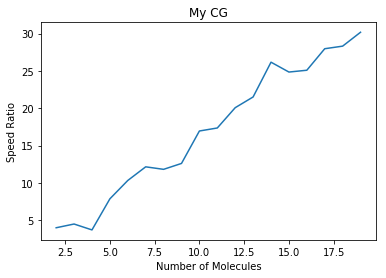

With the analytical gradient, the speed is approximately 2n faster where n is the number of molecules


In [152]:
# Time Test
import matplotlib.pyplot as plt
import time

t1=[]
t2=[]
dim=3
nmin=2
nmax=20
for i in np.arange(nmin,nmax,1):
    A=init(i,dim)
    start=time.time()
    CG(Energy,A.flatten(),args=(dim,))
    end=time.time()
    t1.append(end-start)
    start=time.time()
    CG(Energy,A.flatten(),args=(dim,),fprime=gradientE)
    end=time.time()
    t2.append(end-start)
t1=np.asarray(t1)
t2=np.asarray(t2)




x=np.arange(nmin,nmax,1)
fig=plt.figure()
ax1=fig.add_subplot(111)
ax1.plot(x,t1/t2)#The y axis is the speed of the approximated gradient divided by the speed of the analytical gradient.
ax1.set_xlabel('Number of Molecules')
ax1.set_ylabel('Speed Ratio')
ax1.set_title('My CG')
plt.show()
print('With the analytical gradient, the speed is approximately 2n faster where n is the number of molecules')

In [147]:
def LineSearch(f,fprime,xk,pk,gfk,old_fval,old_old_fval,c1=1e-4, c2=0.9, maxiter=100,  extra_condition=None):
    
    def phi(alpha):
        return f(xk+alpha*pk)
    def phiprime(alpha):
        return np.dot(fprime(xk+alpha*pk),pk)
    

    def zoom(alpha_lo,alpha_hi):
        k=0
        while True:
            y=[alpha_lo,alpha_hi]
            i=0
            k+=1
            if k>200:
                return None
            while i<maxiter:
                i+=1
                alpha_j=chooser(alpha_lo,alpha_hi)
                if extra_condition(alpha_j,None,None,None)==False:
                    continue
                phik=phi(alpha_j)
                if ((phik > (phi(0)+c1*alpha_j*phiprime(0.))) or (phik>=phi(alpha_lo))):
                    alpha_hi=alpha_j
                else:
                    phikprime=phiprime(alpha_j)
                    if np.abs(phikprime)<=-c2*phiprime(0.):
                        return alpha_j
                    if phikprime*(alpha_hi-alpha_lo)>=0.:
                        alpha_hi=alpha_lo
                    alpha_lo=alpha_j
            alpha_lo=y[0]
            alpha_hi=y[1]
            
                    
        
    
    def chooser(alpha_lo,alpha_hi):
        return (np.random.uniform(-1.,1.)*(alpha_hi-alpha_lo)+alpha_lo)
    
    def choose(alpha_lo,alpha_hi,i):
        return (alpha_hi-alpha_lo)*(.01*i)+alpha_lo
    
    
    alphamax=100.
    alpha=np.zeros([2])
    alpha[1]=2*(old_fval-old_old_fval)/phiprime(0.)
    alpha[1]=min(1.,1.01*alpha[1])
    copy=phiprime(alpha[1])

    i=0
    if alpha[1]<0.:
        return None

    while i<maxiter:
        phik=phi(alpha[1])
        if ((phik>(phi(0.)+c1*alpha[1]*phiprime(0.))) or ((phik >=phi(alpha[0])) and i>1)):
            alphastar=zoom(alpha[0],alpha[1])
            return (alphastar,None,None,phi(alphastar),old_fval,None)
        phikprime=phiprime(alpha[1])
        if np.abs(phikprime)<=-c2*phiprime(0):
            alphastar=alpha[1]
            return (alphastar,None,None,phi(alphastar),old_fval,None)
        if phikprime>=0:
            alphastar=zoom(alpha[1],alpha[0])
            return (alphastar,None,None,phi(alphastar),old_fval,None)
        alpha[0]=alpha[1]
        alpha[1]=choose(alpha[1],alphamax,i)
        i+=1
